<a href="https://colab.research.google.com/github/msohail95/FacialExpressionClassification/blob/main/FacialExpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Extraction trainig data

In [3]:
import shutil
dPath='dataset'
os.mkdir(dPath)
shutil.unpack_archive('/content/drive/MyDrive/train_and_val_set.tar',dPath)

In [4]:
import numpy as np

In [5]:
d=os.listdir('/content/dataset/train_set/images')

In [6]:
import csv

# Creating CSV file

In [7]:
fields = ['Image', 'val', 'aro', 'exp']

In [8]:
filename = "/content/facial_data.csv"

In [10]:

rows=[]
with open(filename, 'w') as csvfile: 
  csvwriter = csv.writer(csvfile)
  
  csvwriter.writerow(fields)
  for j in range(len(d)):
    b=''
    for i in d[j]:
      if i=='.':
        break
      b=b+i
    val=np.load('/content/dataset/train_set/annotations/'+b+'_val.npy')
    aro=np.load('/content/dataset/train_set/annotations/'+b+'_aro.npy')
    exp=np.load('/content/dataset/train_set/annotations/'+b+'_exp.npy')
    row=[]
    row=[d[j],val,aro,exp]
    row=np.array(row)
    rows.append(row)

  csvwriter.writerows(rows)

# Importing libraries

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import pandas as pd
cwd=os.getcwd()
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input

In [12]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [13]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.0 MB/s 


# Reading CSV file

In [75]:
dataframe = pd.read_csv("/content/facial_data.csv") 

# Creating train and validation generators

In [76]:

datagen_res=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.resnet.preprocess_input)
train= datagen_res.flow_from_dataframe(
    dataframe=dataframe,
    directory='/content/dataset/train_set/images',
    x_col="Image",
    y_col=['val', 'aro', 'exp'],
    image_size=(224,224),
    batch_size=8,
    class_mode="multi_output",
    subset='training',
    shuffle=True
    )

val= datagen_res.flow_from_dataframe(
    dataframe=dataframe,
    directory='/content/dataset/train_set/images',
    x_col="Image",
    y_col=['val', 'aro', 'exp'],
    image_size=(224,224),
    batch_size=8,
    class_mode="multi_output",
    subset='validation',
    shuffle=True
    )

Found 230121 validated image filenames.
Found 57530 validated image filenames.


# Sample images from train and validation set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


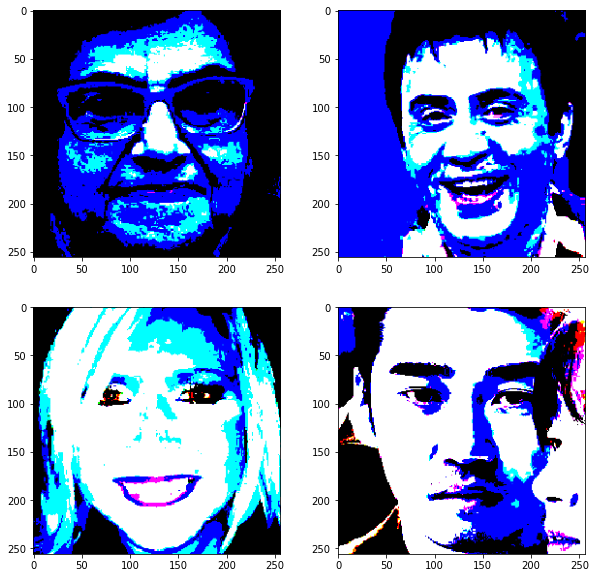

In [17]:
fig , axs = plt.subplots(2,2 ,figsize = (10,10))

axs[0][0].imshow(train[1][0][0])
axs[0][1].imshow(train[2][0][0])
axs[1][1].imshow(train[3][0][0])
axs[1][0].imshow(train[4][0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


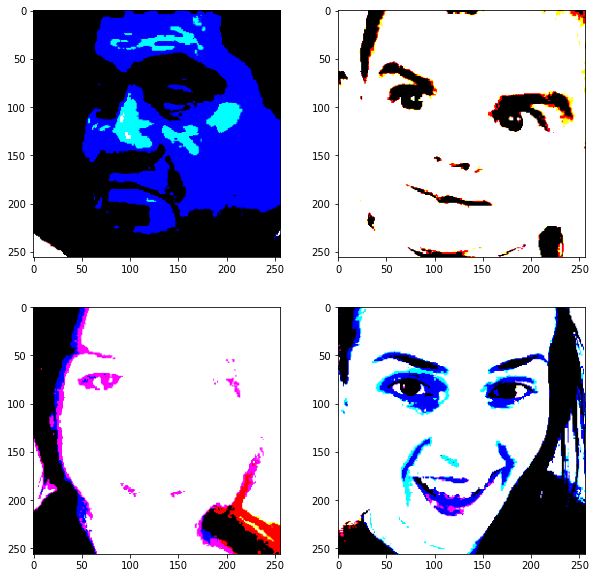

In [24]:
fig , axs = plt.subplots(2,2 ,figsize = (10,10))

axs[0][0].imshow(val[1][0][0])
axs[0][1].imshow(val[2][0][0])
axs[1][1].imshow(val[30][0][0])
axs[1][0].imshow(val[4][0][0])

# Using pretrain VGG19

In [18]:
vgg19=keras.applications.VGG19(weights="imagenet",
                             include_top=False,
                             input_shape =(224, 224,3))

80150528/80134624 [==============================] - 1s 0us/step


In [19]:
flt = GlobalAveragePooling2D()(vgg19.input)
fc = Dense(1024, activation='relu')(flt)
expression = Dense(8, name='expression')(fc)
valence = Dense(1, activation='linear', name='valence')(fc)
arrousal = Dense(1, activation='linear', name='arrousal')(fc)

In [20]:
model = Model(inputs=vgg19.input, outputs=[expression,valence,arrousal])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 3)           0           ['input_1[0][0]']                
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 1024)         4096        ['global_average_pooling2d[0][0]'
                                                                 ]                            

In [25]:
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy

## Compiling model

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError()], metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001),loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError()],
                    loss_weights={'expression': 5, 'valence': 0.25, 'arrousal':0.25}, metrics={'expression':'accuracy','expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True),'valence': 'RootMeanSquaredError', 'arrousal':'RootMeanSquaredError'})

## Training model

In [29]:
h = model.fit_generator(train, epochs=10, validation_data=val, validation_steps=5)

Epoch 1/10
    1/28766 [..............................] - ETA: 32:41 - loss: 0.0445 - expression_loss: 0.0000e+00 - valence_loss: 0.1778 - expression_cohen_kappa: nan - valence_root_mean_squared_error: 0.4217 - arrousal_root_mean_squared_error: 2.3040

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


28766/28766 [==============================] - 705s 25ms/step - loss: 0.0253 - expression_loss: 8.4812e-07 - valence_loss: 0.1013 - expression_cohen_kappa: nan - valence_root_mean_squared_error: 0.3183 - arrousal_root_mean_squared_error: 2.9065 - val_loss: 0.0234 - val_expression_loss: 0.0000e+00 - val_valence_loss: 0.0937 - val_expression_cohen_kappa: nan - val_valence_root_mean_squared_error: 0.3061 - val_arrousal_root_mean_squared_error: 3.4909
Epoch 2/10
28766/28766 [==============================] - 728s 25ms/step - loss: 0.0249 - expression_loss: 8.3954e-07 - valence_loss: 0.0994 - expression_cohen_kappa: nan - valence_root_mean_squared_error: 0.3153 - arrousal_root_mean_squared_error: 3.0725 - val_loss: 0.0214 - val_expression_loss: 0.0000e+00 - val_valence_loss: 0.0856 - val_expression_cohen_kappa: nan - val_valence_root_mean_squared_error: 0.2927 - val_arrousal_root_mean_squared_error: 3.0100
Epoch 3/10
28766/28766 [==============================] - 703s 24ms/step - loss: 0.02

In [30]:
model.save("/content/drive/MyDrive/data_Facial/facialVGG19.h5")

# Reading test data

In [34]:
tPath='testdata'
os.mkdir(tPath)
shutil.unpack_archive('/content/drive/MyDrive/test_set.tar',tPath)

In [35]:
d=os.listdir('/content/testdata/val_set/images')

In [36]:
fields = ['Image', 'val', 'aro', 'exp']

In [38]:
filename = "/content/test_data.csv"
rows=[]
with open(filename, 'w') as csvfile: 
  csvwriter = csv.writer(csvfile)
  
  csvwriter.writerow(fields)
  for j in range(len(d)):
    b=''
    for i in d[j]:
      if i=='.':
        break
      b=b+i
    val=np.load('/content/testdata/val_set/annotations/'+b+'_val.npy')
    aro=np.load('/content/testdata/val_set/annotations/'+b+'_aro.npy')
    exp=np.load('/content/testdata/val_set/annotations/'+b+'_exp.npy')
    row=[]
    row=[d[j],val,aro,exp]
    row=np.array(row)
    rows.append(row)

  csvwriter.writerows(rows)

In [81]:
dataframe = pd.read_csv("/content/test_data.csv") 
test= datagen_res.flow_from_dataframe(
    dataframe=dataframe,
    directory='/content/testdata/val_set/images',
    x_col="Image",
    y_col=['val', 'aro', 'exp'],
    image_size=(224,224),
    batch_size=8,
    class_mode="multi_output",
    shuffle=True
    )

Found 3999 validated image filenames.


# Quantitative results

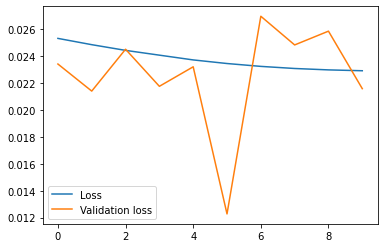

In [48]:

plt.plot(h.history['loss'], label="Loss")
plt.plot(h.history['val_loss'], label="Validation loss")
plt.legend()


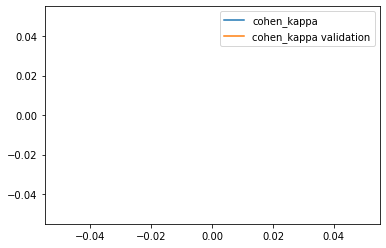

In [64]:
plt.plot(h.history['expression_cohen_kappa'], label="cohen_kappa")
plt.plot(h.history['val_expression_cohen_kappa'], label="cohen_kappa validation")
plt.legend()

In [53]:
import sklearn.metrics as metrics

In [57]:
steps=5
y_true=dataframe['exp']
expr, vala, aros = model.predict_generator(test, steps=steps)
pred = np.argmax(expr, axis=1)
true=y_true[:len(pred)] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
print(metrics.classification_report(true, pred))
m=np.mean(np.sign(true) == np.sign(pred))
print("SAGR : {}".format(m))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         6

    accuracy                           0.05        40
   macro avg       0.01      0.12      0.01        40
weighted avg       0.00      0.05      0.00        40

SAGR : 0.05


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Qualitative results

In [59]:
emo, val, aro = model.predict_generator(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [60]:
import cv2

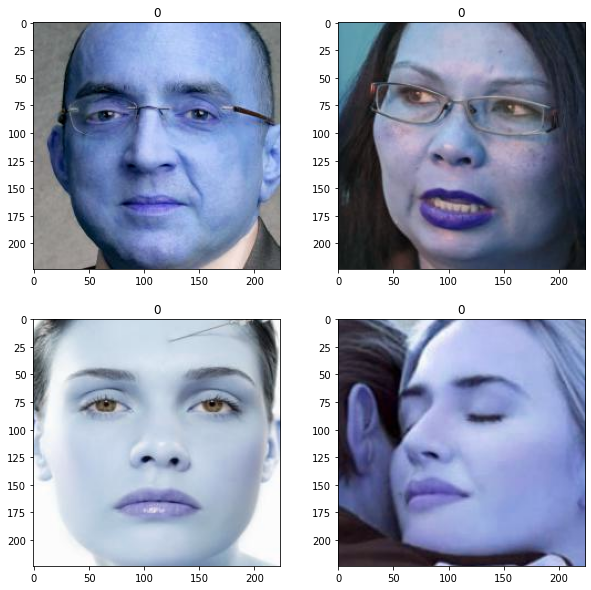

In [66]:
predictions = np.argmax(emo, axis=1)
image_paths = dataframe['Image'][:len(predictions)]   
true_class=dataframe['exp'][:len(predictions)]  
correct_preds = np.array(true_class) == np.array(predictions)
correct_inds, incorrect_inds = [],[]

for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))


imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread('/content/testdata/val_set/images/'+image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    ax.imshow(img)
    ax.set_title(l)
plt.show()


# Pretrained Resnet50

In [67]:
resnet=keras.applications.ResNet50(weights="imagenet",
                             include_top=False,
                             input_shape =(224, 224,3))

94781440/94765736 [==============================] - 1s 0us/step


In [68]:
flt = GlobalAveragePooling2D()(resnet.input)
fc = Dense(2048, activation='relu')(flt)
fc = Dense(1024, activation='relu')(fc)
expression = Dense(8, name='expression')(fc)
valence = Dense(1, activation='linear', name='valence')(fc)
arrousal = Dense(1, activation='linear', name='arrousal')(fc)

In [69]:
res = Model(inputs=resnet.input, outputs=[expression,valence,arrousal])

In [70]:
res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 3)           0           ['input_2[0][0]']                
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 2048)         8192        ['global_average_pooling2d_1[0][0
                                                                 ]']                        

## Compiling model

In [71]:
res.compile(optimizer=Adam(learning_rate=0.001), loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError()], metrics=['accuracy'])
res.compile(optimizer=Adam(learning_rate=0.0001),loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError()],
                    loss_weights={'expression': 5, 'valence': 0.25, 'arrousal':0.25}, metrics={'expression':'accuracy','expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True),'valence': 'RootMeanSquaredError', 'arrousal':'RootMeanSquaredError'})

## Training model

In [77]:
hist = res.fit_generator(train, epochs=10, validation_data=val, validation_steps=5)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


28766/28766 [==============================] - 807s 28ms/step - loss: 0.0338 - expression_loss: 1.5337e-04 - valence_loss: 0.1320 - expression_cohen_kappa: 0.0000e+00 - valence_root_mean_squared_error: 0.3633 - arrousal_root_mean_squared_error: 4.0032 - val_loss: 0.0152 - val_expression_loss: 1.3709e-07 - val_valence_loss: 0.0606 - val_expression_cohen_kappa: nan - val_valence_root_mean_squared_error: 0.2462 - val_arrousal_root_mean_squared_error: 2.1978
Epoch 2/10
28766/28766 [==============================] - 824s 29ms/step - loss: 0.0229 - expression_loss: 3.6008e-07 - valence_loss: 0.0915 - expression_cohen_kappa: nan - valence_root_mean_squared_error: 0.3025 - arrousal_root_mean_squared_error: 2.9368 - val_loss: 0.0240 - val_expression_loss: 2.0862e-08 - val_valence_loss: 0.0961 - val_expression_cohen_kappa: nan - val_valence_root_mean_squared_error: 0.3101 - val_arrousal_root_mean_squared_error: 3.0444
Epoch 3/10
28766/28766 [==============================] - 780s 27ms/step - los

In [78]:
res.save("/content/drive/MyDrive/data_Facial/facialResnet50.h5")

## Quantitative Results

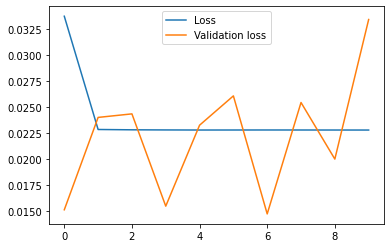

In [79]:

plt.plot(hist.history['loss'], label="Loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()


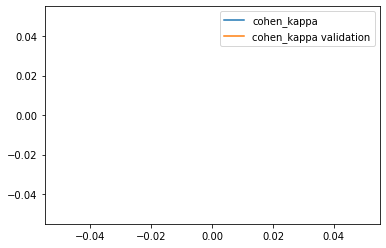

In [80]:
plt.plot(hist.history['expression_cohen_kappa'], label="cohen_kappa")
plt.plot(hist.history['val_expression_cohen_kappa'], label="cohen_kappa validation")
plt.legend()

In [82]:
steps=5
y_true=dataframe['exp']
expr, vala, aros = res.predict_generator(test, steps=steps)
pred = np.argmax(expr, axis=1)
true=y_true[:len(pred)] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
print(metrics.classification_report(true, pred))
m=np.mean(np.sign(true) == np.sign(pred))
print("SAGR : {}".format(m))

              precision    recall  f1-score   support

           0       0.05      1.00      0.10         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         6

    accuracy                           0.05        40
   macro avg       0.01      0.12      0.01        40
weighted avg       0.00      0.05      0.00        40

SAGR : 0.05


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Qualitative Results

In [84]:
emo, val, aro = res.predict_generator(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


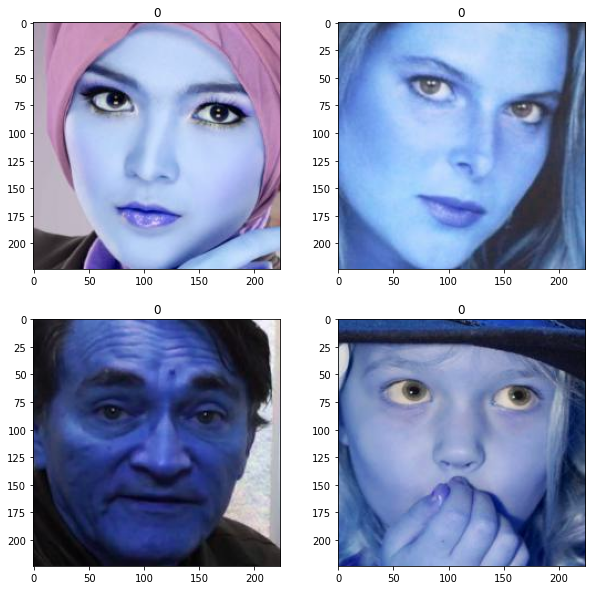

In [85]:
predictions = np.argmax(emo, axis=1)
image_paths = dataframe['Image'][:len(predictions)]   
true_class=dataframe['exp'][:len(predictions)]  
correct_preds = np.array(true_class) == np.array(predictions)
correct_inds, incorrect_inds = [],[]

for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))


imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread('/content/testdata/val_set/images/'+image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    ax.imshow(img)
    ax.set_title(l)
plt.show()
